## Using Remote Sensing to Predict and Understand Future Wildfires
### by Zeynep Ankut, Isaiah Stene, Corey Becker

Does the needed imports and downloads the dataset (takes like 5 minutes)

In [4]:
import importFunctions as imp 
import kagglehub

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


path = kagglehub.dataset_download("fantineh/next-day-wildfire-spread")
print("Path to dataset files:", path)

train_files = path + "/next_day_wildfire_spread_train*"
test_files = path + "/next_day_wildfire_spread_test*"
eval_files = path + "/next_day_wildfire_spread_eval*"


train = imp.get_dataset(train_files,  
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

test = imp.get_dataset(test_files,  
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)


eval_data = imp.get_dataset(test_files,  
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

c:\Users\theco\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\theco\.cache\kagglehub\datasets\fantineh\next-day-wildfire-spread\versions\2


In [5]:
def plotRows(start,end,titles,n_features,data):
  inputs, labels = next(iter(data))

  fig = plt.figure(figsize=(15,6.5))

  CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
  BOUNDS = [-1, -0.1, 0.001, 1]
  NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

  n_rows = end-start
  for i in range(n_rows):
    for j in range(n_features + 1):
      plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
      if i == 0:
        plt.title(titles[j], fontsize=13)
      if j < n_features - 1:
        plt.imshow(inputs[i+start, :, :, j], cmap='viridis')
      if j == n_features - 1:
        plt.imshow(inputs[i+start, :, :, -1], cmap=CMAP, norm=NORM)
      if j == n_features:
        plt.imshow(labels[i+start, :, :, 0], cmap=CMAP, norm=NORM) 
      plt.axis('off')
  plt.tight_layout()

  plt.show()

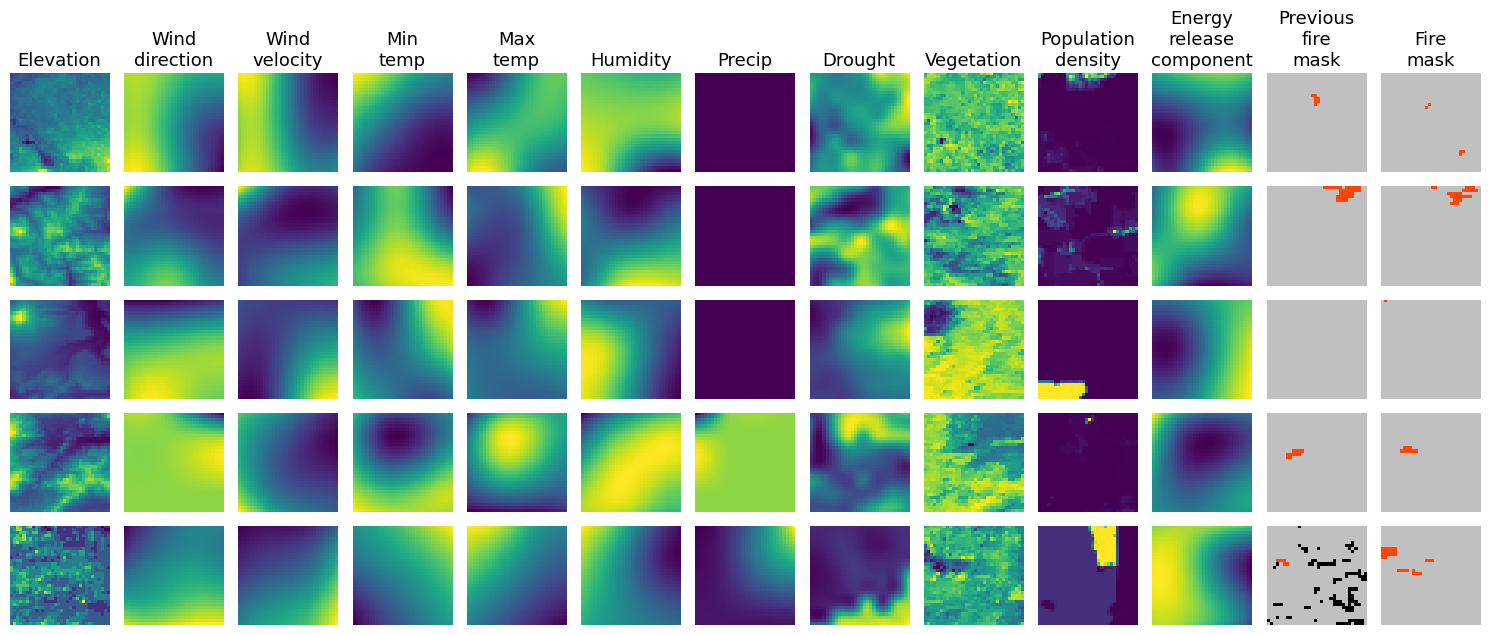

In [6]:
titles = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

plotRows(20,25,titles,len(titles)-1, train)

In [7]:
inputs, labels = next(iter(train))
# print(labels.shape)

n_fires, height,width, feat_images = inputs.shape

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, feat_images)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3)) # there are 3 outputs: fire, no fire, and no data

model.summary()

(100, 32, 32, 1)


c:\Users\theco\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,707 (487.14 KB)

 Trainable params: 124,707 (487.14 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:

t_inputs, t_labels = next(iter(test))
e_inputs, e_labels = next(iter(eval_data))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(inputs, labels, epochs=10, 
                    validation_data=(e_inputs, e_labels))


Epoch 1/10


ValueError: Argument `output` must have rank (ndim) `target.ndim - 1`. Received: target.shape=(None, 32, 32, 1), output.shape=(None, 3)

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(e_inputs,  e_labels, verbose=2)

print(test_acc)